# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="plot-the-data-1" href="#plot-the-data"><span class="toc-item-num">1&nbsp;&nbsp;</span>plot the data</a></div><div class="lev1 toc-item"><a data-toc-modified-id="simple-divergence-model-2" href="#simple-divergence-model"><span class="toc-item-num">2&nbsp;&nbsp;</span>simple divergence model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-residuals-21" href="#plot-residuals"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plot residuals</a></div><div class="lev1 toc-item"><a data-toc-modified-id="divergence-with-migration-model-3" href="#divergence-with-migration-model"><span class="toc-item-num">3&nbsp;&nbsp;</span>divergence with migration model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="plot-residuals-31" href="#plot-residuals"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>plot residuals</a></div><div class="lev2 toc-item"><a data-toc-modified-id="LRT-32" href="#LRT"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LRT</a></div>

In [71]:
import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [72]:
# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

In [73]:
# print number of segregating sites in the SFS

sfs2d_unfolded.S()

60573.584426000001

The 2D spectrum contains counts from 60k sites that are variable in *par* or *ery* or both.

# plot the data

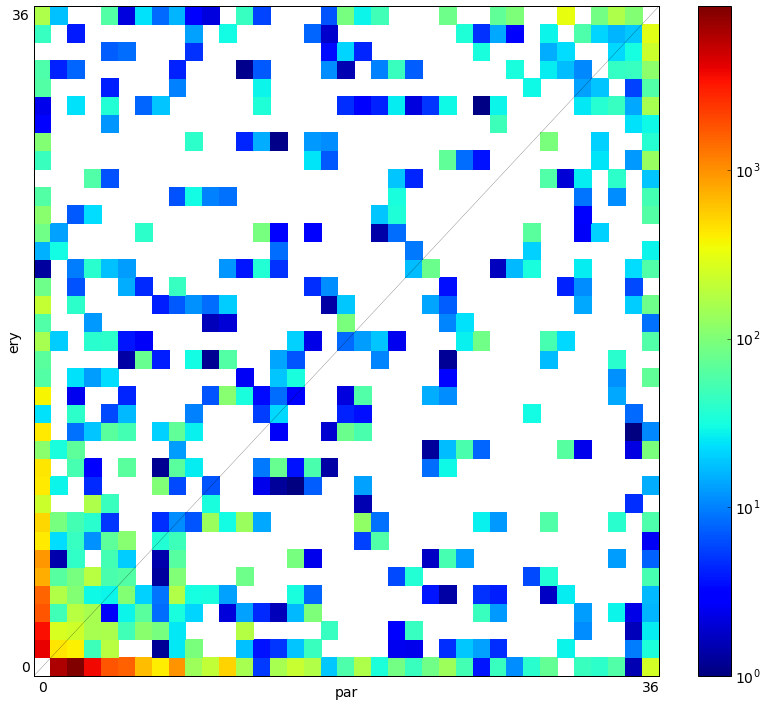

In [74]:
import pylab

%matplotlib inline

pylab.rcParams['font.size'] = 14.0
pylab.rcParams['figure.figsize'] = [14.0, 12.0]

dadi.Plotting.plot_single_2d_sfs(sfs2d_unfolded, vmin=1, cmap=pylab.cm.jet)

Cells with counts below 1 are masked and appear white in the upper plot.

In [75]:
sfs2d_folded = sfs2d_unfolded.fold()

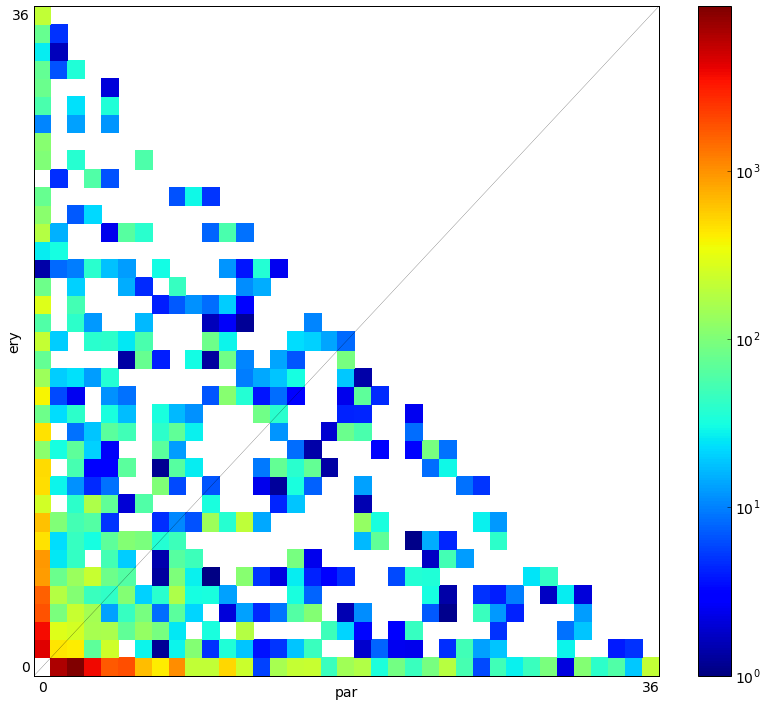

In [76]:
# plot the folded GLOBAL minor allele frequency spectrum

dadi.Plotting.plot_single_2d_sfs(sfs2d_folded, vmin=1, cmap=pylab.cm.jet)

# simple divergence model

In [77]:
def split_nomig(params, ns, pts):
    """
    params = (nu1,nu2,T)
    ns = (n1,n2)

    Split into two populations of specifed size, no migration.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    T: Time in the past of split (in units of 2*Na generations) 
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,T = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)

    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

This model specifies a split of the ancestral population $T \times 2N_{ref}$ generations ago. The two daughter populations have a constant population size until the present of $\nu_1 \times N_{ref}$ and $\nu_2 \times N_{ref}$, respectively.

In [78]:
# load optimisation results from file

import dill, glob

ar_split_nomig = []

for filename in glob.glob("OUT_2D_models/split_nomig*dill"):
    ar_split_nomig.append(dill.load(open(filename)))

In [79]:
from utility_functions import *

In [80]:
import pandas as pd

In [81]:
success = [flatten(out)[:7] for out in ar_split_nomig if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
2,0.877109,0.741007,0.360840,0.636945,1.229606,0.290465,20387.227270
9,0.136711,7.063745,0.075557,0.637653,1.229853,0.290442,20387.435815
3,1.461323,4.088909,2.236886,0.637660,1.229850,0.290445,20387.435815
11,0.854249,1.682438,0.240684,0.637655,1.229849,0.290445,20387.435815
0,0.146030,1.659384,0.282181,0.637644,1.229881,0.290447,20387.435816
5,0.324028,1.847701,0.160416,0.637682,1.229931,0.290459,20387.435816
4,0.248861,4.984686,0.085569,0.637683,1.229911,0.290450,20387.435817
7,0.201540,0.651162,0.031593,0.637639,1.229858,0.290441,20387.435817
10,0.533901,0.839080,0.139849,0.637653,1.229835,0.290444,20387.435818
1,0.218471,1.740969,0.295402,0.637657,1.229890,0.290440,20387.435819


The optimal parameter values look very robust: very different starting values converge to almost identical optimal parameter values.

In [82]:
# create link
func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

ns = sfs2d_folded.sample_sizes

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

In [83]:
# calculate best-fit model spectrum

model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

In [84]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)

In [85]:
print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))

The optimal value of theta for the ancestral population is 9347.


In [86]:
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 688,875.


I am assuming that $\nu_1$ refers to _ery_ and $\nu_2$ refers to _par_. The `split_nomig` model with its optimal parameter values suggests the following:

In [87]:
print "The ancestral population of ery and par split apart {2:,} generations ago. Since then until present the ery population had a size of {0:,} and the par population of {1:,}.".format(int(0.636945*N_ref), int(1.229606*N_ref)
, int(0.290465*2*N_ref))

The ancestral population of ery and par split apart 400,188 generations ago. Since then until present the ery population had a size of 438,776 and the par population of 847,045.


Note, that the fitting of 1D models to the spectra of each population had indicated a population size _reduction_ for both populations and more so for _parallelus_, which seems to contradict what this 2D model says about the two populations.

## plot residuals

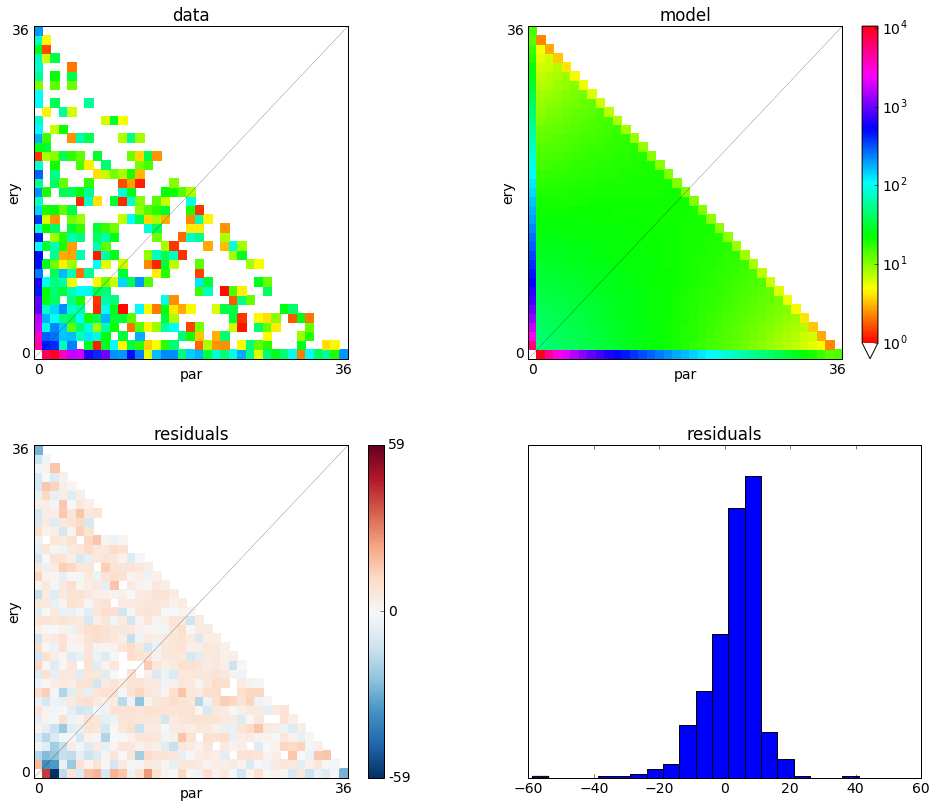

In [88]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

The residuals show that the best-fit model has a deficit of fixed divergent SNP's as well as of low frequency shared SNP's. Maybe the fit can be improved by introducing gene flow.

# divergence with migration model

In [89]:
func = dadi.Demographics2D.split_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

This model adds a single migration rate parameter $m$ . It is assumed that migration is of equal size $m$ in each direction.

In [90]:
# load optimisation results from file

ar_split_mig = []

for filename in glob.glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig.append(dill.load(open(filename)))

In [91]:
success = [flatten(out)[:9] for out in ar_split_mig if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
8,2.059032,0.360002,0.682463,0.192790,0.994185,1.766127,0.922632,2.506880e-01,18574.119915
31,0.620927,0.849787,1.980000,1.827165,0.994247,1.766242,0.922690,2.507990e-01,18574.120405
2,2.894370,11.363772,1.980000,0.272765,0.993365,1.764405,0.921871,2.509119e-01,18574.121486
28,0.631049,2.924698,0.247732,0.205392,0.993307,1.765318,0.921817,2.509740e-01,18574.122241
17,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
18,5.535163,3.398472,0.309525,0.169667,0.993863,1.767477,0.925657,2.517209e-01,18574.159471
15,0.318463,0.315764,0.587406,1.138654,0.989922,1.761280,0.914716,2.507331e-01,18574.164848
1,0.277233,8.221059,0.976626,0.051974,1.001148,1.776879,0.937823,2.505879e-01,18574.226541
0,5.653430,3.362330,1.980000,0.101259,0.995994,1.769480,0.927834,2.507786e-01,18574.341908
33,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801


From many different initial parameter value combinations the optimisations converge on essentially the same set of parameters that includes a migration rate that is not 0. This optimal parameter combination is much more likely than the other combinations. From many initial parameter values the optimisations converge to a model that is essentially the same as the split-no-migration model from above. However, these parameter combinations have much lower likelihood.

In [93]:
popt = numpy.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

# calculate best-fit model spectrum

model_spectrum = func_ex(popt, ns, pts_l)

theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)

print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4

The optimal value of theta for the ancestral population is 6354.
The total sequence length for the 2D spectrum is 1,130,775.


## plot residuals

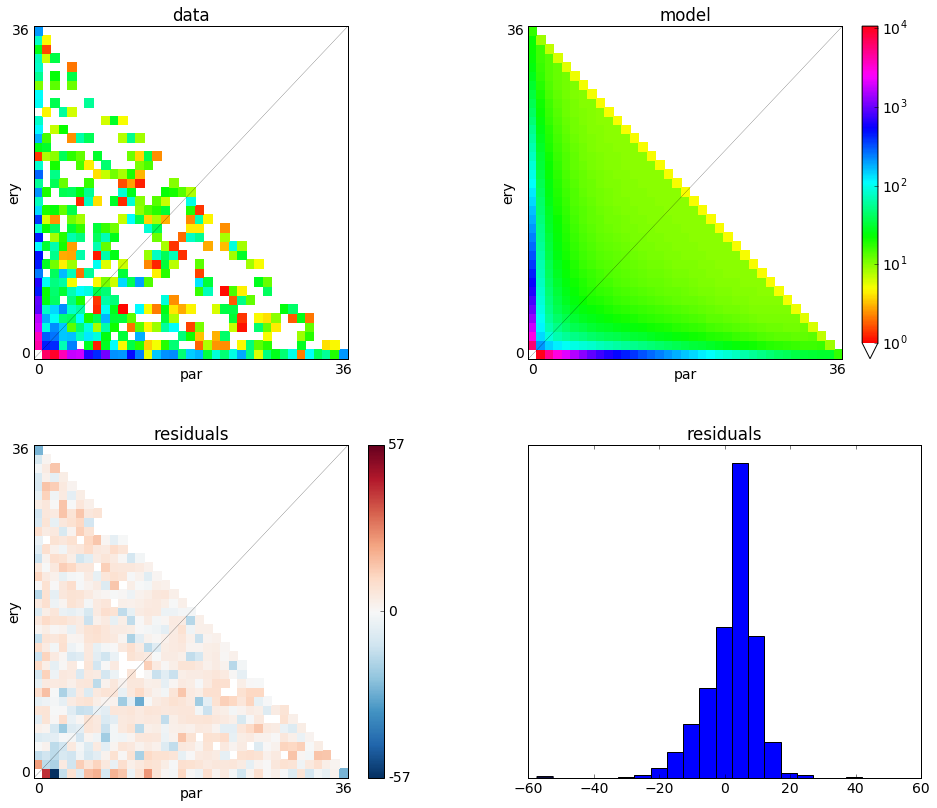

In [94]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

This has reduced the residuals for low frequency shared polymorphisms, but the model still cannot fit divergently fixed SNP's well.

What this model fit says in plain English:

In [67]:
print "The ancestral population split apart {2:,} generation ago. Since then, ery and par had a constant population size of {0:,} and {1:,}, respectively. The two diverging populations were exchanging one diploid migrant in each direction every {3:.2f} genertions.".format(int(popt[0]*N_ref), int(popt[1]*N_ref), int(popt[2]*2*N_ref), 1.0/popt[3])

The ancestral population split apart 864,128 generation ago. Since then, ery and par had a constant population size of 465,572 and 827,069, respectively. The two diverging populations were exchanging one diploid migrant in each direction every 3.99 genertions.


The dadi manual says about the migration rate parameter (on page 11):

>The migration parameter m12 specifies the rate of migration from pop 2 into pop 1. It is equal to the fraction of individuals each generation in pop 1 that are new migrants from pop 2, times the 2Nref.

So the migration rate has units of number of diploid immigrant individuals per generation.

## LRT

Is the model *with* migration significantly better than the model *without* migration?

From the dadi manual:

>The full likelihood ratio test statistic is equal to $D = 2(ll_c - ll_s)$ where $ll_c$ and $ll_s$ are the likelihoods of the complex and simple model, respectively.

$D$ should be $\chi^2$ distributed

>with degrees of freedom equal to the difference in number of parameters between the simple and complex model.

Not all SNP's in the spectrum will be unlinked with each other. Therefore, the *likelihoods* calculated are *composite likelihoods*. Dadi can calculate an adjustment factor for $D$ that corrects for linkage. However, this requires bootstrapped data sets, which I haven't created yet. In the following calculation I am assuming that all SNP's can be assumed independent data points.

In [68]:
# calculate logL for split-migration model
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

# calculate best-fit model spectrum with optimal parameter values
model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

# calculate logL for split-no-migration model
ll_s = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [69]:
D = 2*(ll_c - ll_s)
D

3626.2146620022322

In [70]:
# calculate p-value for Chi-square dist. with 1 degree of freedom
p = dadi.Godambe.sum_chi2_ppf(D)
p

0.0

Gene flow significantly improves the fit to the observed spectrum. I doubt that there could be enough linkage in the data to compromise this result.